In [1]:
BLACKHOLE = True


import os
import sys
from pathlib import Path
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # fixes problem with graph


if BLACKHOLE:
    workspace_path = os.path.expandvars('$BLACKHOLE')
    sys.path.append(workspace_path+'/DeepLearning/02456_news_project/src')
    DATAPATH = Path(workspace_path+"/DeepLearning/ebnerd_data").expanduser()
else:
    DATAPATH = Path("~/ebnerd_data").expanduser()

DATASET = "ebnerd_demo"
#DATASET = "ebnerd_small"
#DATASET = "ebnerd_large"

In [2]:
import torch

print("torch version:", torch.__version__)

# Check gpu availability


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Test:
#print(torch.zeros(1).cuda())

torch version: 2.5.1+cu124
cuda


In [3]:
from utils.data_handler import NewsDataset
import from_ebrec._constants as cs

SEED = 42
HISTORY_SIZE = 30
CANDITATE_SIZE = 5

COLS = [
    cs.DEFAULT_USER_COL,
    cs.DEFAULT_IMPRESSION_ID_COL,
    cs.DEFAULT_IMPRESSION_TIMESTAMP_COL,
    cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    cs.DEFAULT_CLICKED_ARTICLES_COL,
    cs.DEFAULT_INVIEW_ARTICLES_COL,
]

FRACTION = 0.001
#FRACTION = 0.01
#FRACTION = 0.1
#FRACTION = 1

# test
dataset = NewsDataset()

dataset.setup_df(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED, candidate_size=CANDITATE_SIZE)


In [4]:
import transformers as huggingface
from from_ebrec._nlp import get_transformers_word_embeddings
from from_ebrec._polars import concat_str_columns
from from_ebrec._articles import convert_text2encoding_with_transformers
from from_ebrec._articles import create_article_id_to_value_mapping

dataset.setup_articles_data(dataset_path = DATAPATH.joinpath(DATASET))

df_articles = dataset.df_articles

TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-large"
TEXT_COLUMNS_TO_USE = [cs.DEFAULT_SUBTITLE_COL, cs.DEFAULT_TITLE_COL]
MAX_TITLE_LENGTH = 30

# LOAD HUGGINGFACE:
transformer_model = huggingface.AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = huggingface.AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

word2vec_embedding = get_transformers_word_embeddings(transformer_model)
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH)
article_mapping = create_article_id_to_value_mapping(df=df_articles, value_col=token_col_title)



In [ ]:
from nrms import NRMSModel
from hyperparameters import hparams_nrms

hparams = hparams_nrms()

BATCH_SIZE = 64

# PARAMETERS
hparams.title_size = MAX_TITLE_LENGTH
hparams.history_size = HISTORY_SIZE
hparams.batch_size = BATCH_SIZE
hparams.candidate_size = CANDITATE_SIZE

# MODEL ARCHITECTURE
hparams.head_num = 32
hparams.head_dim = 32
hparams.attention_hidden_dim = 200
hparams.linear_hidden_dim = 2000
hparams.embedding_dim = word2vec_embedding.shape[1]

hparams.use_positional_encoding = True

hparams.use_time_embedding = False
hparams.time_dim = 1
hparams.time_embedding_dim = 32

# MODEL OPTIMIZER:
hparams.optimizer = "adam"
hparams.loss = "mse_loss"
hparams.dropout = 0.2
hparams.learning_rate = 1e-4
hparams.weight_decay = 1e-5

model = NRMSModel(hparams=hparams, word2vec_embedding=word2vec_embedding)

print(model)


NRMSModel(
  (news_encoder): NewsEncoder(
    (embedding): Embedding(250002, 1024)
    (dropout): Dropout(p=0.2, inplace=False)
    (positional_encoder): PositionEncoder(
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (self_attention): SelfAttention(
      (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (dense_layers): Sequential(
      (0): Linear(in_features=1024, out_features=200, bias=True)
      (1): ReLU()
      (2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): ReLU()
      (6): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=200, out_features=1024, bias=True)
      (9): ReLU()
      (10): LayerN

In [6]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function and optimizer
if hparams.loss == "cross_entropy_loss":
    criterion = nn.CrossEntropyLoss() 
elif hparams.loss == "mse_loss":
    criterion = nn.MSELoss()
else:
    raise ValueError(f"Loss function {hparams.loss} not supported")

if hparams.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=hparams_nrms.learning_rate, weight_decay= hparams_nrms.weight_decay)
else:
    raise ValueError(f"Optimizer {hparams.optimizer} not supported")

In [7]:
from dataloader import NRMSDataLoader


train_dataloader = NRMSDataLoader(
    behaviors= dataset.df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE,
)
val_dataloader = NRMSDataLoader(
    behaviors= dataset.df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE,
)

In [8]:
# Train the model 

EPOCHS = 10

# Move model to GPU if available
model.to(device)

# Training loop
train_loss_history, val_loss_history = [], []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for iteration, (data, labels) in enumerate(train_dataloader):
        # Unpacking of batch
        his_input_title, pred_input_title, timestamps = data

        # Move data to device
        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)

        labels = labels.to(device)

        # Forward pass
        outputs = model(pred_input_title, his_input_title)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        print(f"Epoch {epoch + 1}/{EPOCHS}, Train iteration {iteration + 1}/{len(train_dataloader)}: Loss = {loss.item():.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for iteration, (data, labels) in enumerate(val_dataloader):
            his_input_title, pred_input_title, timestamps = data

            his_input_title = his_input_title.to(device)
            pred_input_title = pred_input_title.to(device)
            labels = labels.to(device)

            outputs = model(pred_input_title, his_input_title)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()

            print(f"Epoch {epoch + 1}/{EPOCHS}, Val iteration {iteration + 1}/{len(val_dataloader)}: Loss = {loss.item():.4f}")

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Epoch 1/10, Train iteration 1/1: Loss = 0.2537
Epoch 1/10, Val iteration 1/1: Loss = 0.1895
Epoch 1/10: Train Loss = 0.2537, Val Loss = 0.1895
Epoch 2/10, Train iteration 1/1: Loss = 0.2993
Epoch 2/10, Val iteration 1/1: Loss = 0.2076
Epoch 2/10: Train Loss = 0.2993, Val Loss = 0.2076
Epoch 3/10, Train iteration 1/1: Loss = 0.3015
Epoch 3/10, Val iteration 1/1: Loss = 0.2026
Epoch 3/10: Train Loss = 0.3015, Val Loss = 0.2026
Epoch 4/10, Train iteration 1/1: Loss = 0.2601
Epoch 4/10, Val iteration 1/1: Loss = 0.2130
Epoch 4/10: Train Loss = 0.2601, Val Loss = 0.2130
Epoch 5/10, Train iteration 1/1: Loss = 0.2129
Epoch 5/10, Val iteration 1/1: Loss = 0.2087
Epoch 5/10: Train Loss = 0.2129, Val Loss = 0.2087
Epoch 6/10, Train iteration 1/1: Loss = 0.2595
Epoch 6/10, Val iteration 1/1: Loss = 0.2108
Epoch 6/10: Train Loss = 0.2595, Val Loss = 0.2108
Epoch 7/10, Train iteration 1/1: Loss = 0.1875
Epoch 7/10, Val iteration 1/1: Loss = 0.2123
Epoch 7/10: Train Loss = 0.1875, Val Loss = 0.2123

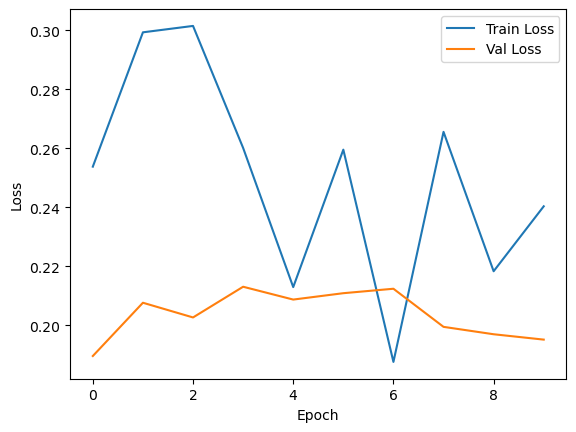

In [9]:
# Plot the loss history
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [10]:
# Evaluate the model
BATCH_SIZE_TEST = 10

dataset.setup_test_data(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED, candidate_size=CANDITATE_SIZE)

test_dataloader = NRMSDataLoader(
    behaviors=dataset.df_test,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE_TEST,
)

model.eval()

test_loss = 0.0
pred_test = []
labels_test = []
with torch.no_grad():  
    for iteration, (data, labels) in enumerate(test_dataloader):
        his_input_title, pred_input_title, timestamps = data

        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)
        labels = labels.to(device)

        outputs = model(pred_input_title, his_input_title) 
        loss = criterion(outputs, labels)                 
        test_loss += loss.item()

        for i in range(outputs.size(0)):
            pred_test.append(outputs[i].tolist())
            labels_test.append(labels[i].tolist())

        print(f"Test iteration {iteration + 1}/{len(test_dataloader)}: Loss = {loss.item():.4f}")

    test_loss /= len(test_dataloader)
    print("Test loss:", test_loss)
        
print(pred_test)
print(labels_test)

from from_ebrec.evaluation import MetricEvaluator
from from_ebrec.evaluation import AucScore, MrrScore, NdcgScore
metrics = MetricEvaluator(
    labels = labels_test,
    predictions= pred_test,
    metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
)
metrics.evaluate()
print(metrics)



Test iteration 1/3: Loss = 0.1732
Test iteration 2/3: Loss = 0.1677
Test iteration 3/3: Loss = 0.1861
Test loss: 0.17568024496237436
[[0.1511216163635254, 0.2897653877735138, 0.23868364095687866, 0.08174571394920349, 0.23868364095687866], [0.2037682682275772, 0.09616485983133316, 0.295405775308609, 0.2037682682275772, 0.2008928656578064], [0.06908931583166122, 0.07123676687479019, 0.06908931583166122, 0.07898588478565216, 0.7115987539291382], [0.22180618345737457, 0.22180618345737457, 0.2036227136850357, 0.23654146492481232, 0.11622349917888641], [0.020614134147763252, 0.17512941360473633, 0.317019522190094, 0.31210756301879883, 0.17512941360473633], [0.0905357375741005, 0.2773304283618927, 0.3388441801071167, 0.20275399088859558, 0.0905357375741005], [0.29745954275131226, 0.049325134605169296, 0.03717143088579178, 0.29745954275131226, 0.3185843825340271], [0.33982565999031067, 0.08401958644390106, 0.33982565999031067, 0.08785507082939148, 0.14847399294376373], [0.14294540882110596, 0.

AUC: 100%|███████████████████████████████████| 25/25 [00:00<00:00, 24995.85it/s]

<MetricEvaluator class>: 
 {
    "auc": 0.55,
    "mrr": 0.506,
    "ndcg@5": 0.6274433694914738,
    "ndcg@10": 0.6274433694914738
}


In [13]:
number_to_print = 20
print("Top %d predictions vs labels:" % number_to_print)
labels = dataset.df_test["labels"].to_list()
for i in range(number_to_print):
    print(f"Article {i}")
    for j in range(len(pred_test[i])):
        print(f"{pred_test[i][j]:.3f} vs {labels[i][j]:.3f}")
    print("")





Top 20 predictions vs labels:
Article 0
0.151 vs 0.000
0.290 vs 0.000
0.239 vs 0.000
0.082 vs 1.000
0.239 vs 0.000

Article 1
0.204 vs 0.000
0.096 vs 0.000
0.295 vs 1.000
0.204 vs 0.000
0.201 vs 0.000

Article 2
0.069 vs 0.000
0.071 vs 1.000
0.069 vs 0.000
0.079 vs 0.000
0.712 vs 0.000

Article 3
0.222 vs 0.000
0.222 vs 0.000
0.204 vs 0.000
0.237 vs 0.000
0.116 vs 1.000

Article 4
0.021 vs 1.000
0.175 vs 0.000
0.317 vs 0.000
0.312 vs 0.000
0.175 vs 0.000

Article 5
0.091 vs 0.000
0.277 vs 1.000
0.339 vs 0.000
0.203 vs 0.000
0.091 vs 0.000

Article 6
0.297 vs 0.000
0.049 vs 0.000
0.037 vs 0.000
0.297 vs 0.000
0.319 vs 1.000

Article 7
0.340 vs 0.000
0.084 vs 0.000
0.340 vs 0.000
0.088 vs 1.000
0.148 vs 0.000

Article 8
0.143 vs 0.000
0.168 vs 0.000
0.457 vs 1.000
0.143 vs 0.000
0.089 vs 0.000

Article 9
0.320 vs 1.000
0.200 vs 0.000
0.200 vs 0.000
0.155 vs 0.000
0.124 vs 0.000

Article 10
0.074 vs 0.000
0.221 vs 1.000
0.330 vs 0.000
0.212 vs 0.000
0.163 vs 0.000

Article 11
0.313 vs 0.0

Confusion Matrix:
[[99  1]
 [25  0]]


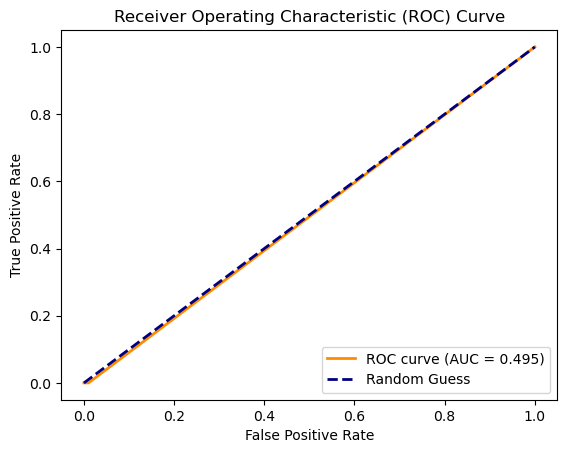

In [14]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


# Flatten the data for analysis
predicted_probabilities = [prob for article in pred_test for prob in article]
true_values = [val for article in labels[:len(pred_test)] for val in article]


# Set a threshold (commonly 0.5) to classify probabilities as 0 or 1
threshold = 0.5
predicted_classes = [1 if p >= threshold else 0 for p in predicted_probabilities]

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_values, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate AUC and ROC curve
fpr, tpr, thresholds = roc_curve(true_values, predicted_classes)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with AUC value explicitly highlighted
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()